Total trades: 728
Profitable trades: 264 (36.26%)
Total P&L: -447197.00 index points (HK$-22359850.00)


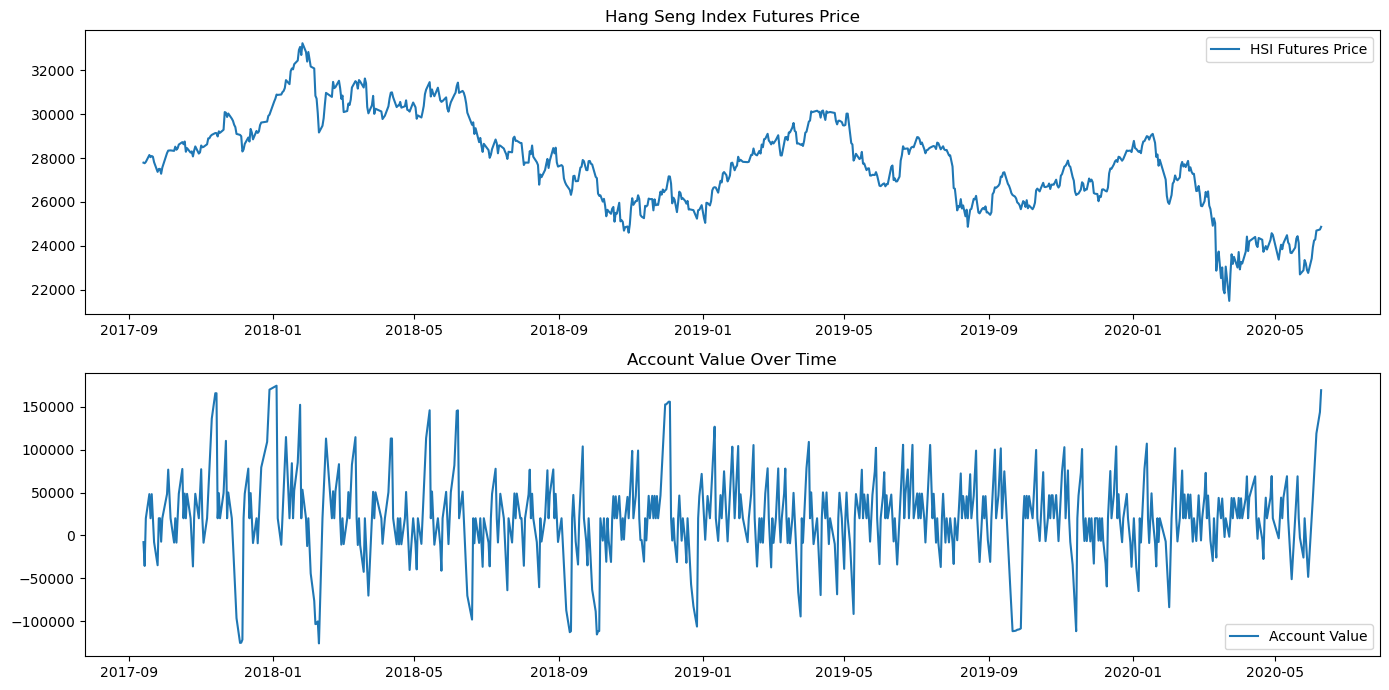

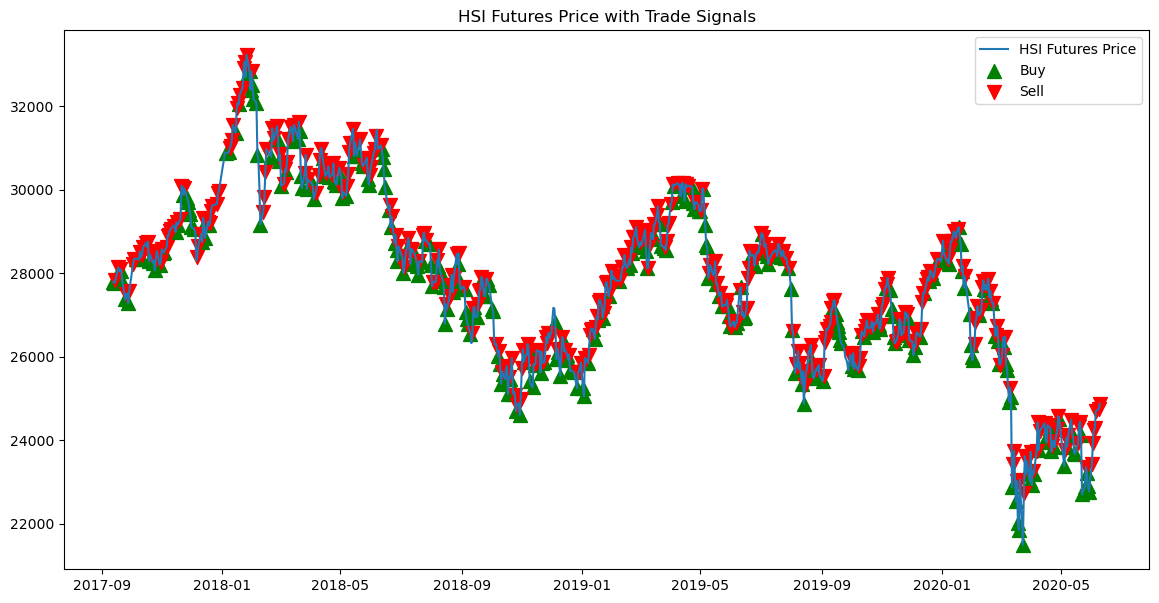

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
# Load the data
data = pd.read_csv('day_K_line.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
data.set_index('date', inplace=True)
data = data.astype(float)  # Convert price columns to float

# Initialize trading parameters
margin_requirement = 0.10  # 10% margin requirement
max_margin_value = 15000   # Maximum margin value (in index points)
account_margin = 20000     # Total account margin (in index points)
transaction_fee = 2        # Fee per contract (in index points)
min_price_change = 2       # Minimum price change to trigger a trade

# Initialize trading variables
position = 0               # Current position (negative for short, positive for long)
trades = []                # List to store trade details
daily_values = []          # Track account value over time

# Start trading from day 52
for i in range(51, len(data)):
    current_date = data.index[i]
    current_price = data['hi1_close'].iloc[i]
    
    # Calculate unrealized PnL from current position
    unrealized_pnl = -position * (current_price - data['hi1_close'].iloc[i-1]) if position != 0 else 0
    
    # Get historical data for ARIMA model
    history = data['hi1_close'].iloc[i-50:i].values
    
    # Fit ARIMA model
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Make prediction for next day
    forecast = model_fit.forecast(steps=1)[0]
    predicted_change = forecast - current_price
    
    # Trading logic
    new_trade = 0
    
    # Calculate required margin for one more contract
    additional_margin = current_price * 0.10
    current_margin = abs(position) * current_price * 0.10
    
    if position > 0:  # Long position
        if predicted_change > min_price_change and (current_margin + additional_margin) < max_margin_value:
            # Buy one more contract
            new_trade = 1
        elif predicted_change < -min_price_change:
            # Close all positions
            new_trade = -position
    elif position < 0:  # Short position
        if predicted_change < -min_price_change and (current_margin + additional_margin) < max_margin_value:
            # Sell one more contract
            new_trade = -1
        elif predicted_change > min_price_change:
            # Close all positions
            new_trade = -position
    else:  # No position
        if predicted_change > min_price_change:
            # Buy one contract
            new_trade = 1
        elif predicted_change < -min_price_change:
            # Sell one contract
            new_trade = -1
    
    # Check if margin would be exceeded
    if abs(position + new_trade) * current_price * 0.10 > max_margin_value:
        new_trade = 0
    
    # Force liquidation if margin exceeds account margin
    if abs(position) * current_price * 0.10 > account_margin:
        new_trade = -position  # Close all positions
        trades.append({
            'date': current_date,
            'price': current_price,
            'trade': new_trade,
            'type': 'Forced liquidation',
            'position_after': 0
        })
    
    # Execute trade if any
    if new_trade != 0:
        trade_cost = abs(new_trade) * transaction_fee
        trade_pnl = 0
        
        if new_trade > 0 and position <= 0:  # Buying to close short or open long
            trade_pnl = -new_trade * current_price - trade_cost
        elif new_trade < 0 and position >= 0:  # Selling to close long or open short
            trade_pnl = -new_trade * current_price - trade_cost
        
        position += new_trade
        
        trades.append({
            'date': current_date,
            'price': current_price,
            'trade': new_trade,
            'cost': trade_cost,
            'pnl': trade_pnl,
            'position_after': position,
            'predicted_change': predicted_change
        })
    
    # Calculate daily account value
    position_value = -position * current_price if position != 0 else 0
    daily_values.append({
        'date': current_date,
        'price': current_price,
        'position': position,
        'unrealized_pnl': unrealized_pnl,
        'account_value': account_margin + position_value
    })

# Convert trades to DataFrame
trades_df = pd.DataFrame(trades)
daily_values_df = pd.DataFrame(daily_values)

# Calculate final results
total_trades = len(trades_df)
profitable_trades = len(trades_df[trades_df['pnl'] > 0])
total_pnl = trades_df['pnl'].sum()
total_pnl_hkd = total_pnl * 50  # Convert index points to HKD

# Print results
print(f"Total trades: {total_trades}")
print(f"Profitable trades: {profitable_trades} ({profitable_trades/total_trades*100:.2f}%)")
print(f"Total P&L: {total_pnl:.2f} index points (HK${total_pnl_hkd:.2f})")

# Plot results
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data.index[51:], data['hi1_close'].iloc[51:], label='HSI Futures Price')
plt.title('Hang Seng Index Futures Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(daily_values_df['date'], daily_values_df['account_value'], label='Account Value')
plt.title('Account Value Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Plot trade positions
plt.figure(figsize=(14, 7))
plt.plot(data.index[51:], data['hi1_close'].iloc[51:], label='HSI Futures Price')

# Mark buy and sell points
buys = trades_df[trades_df['trade'] > 0]
sells = trades_df[trades_df['trade'] < 0]

plt.scatter(buys['date'], data.loc[buys['date']]['hi1_close'], marker='^', color='g', s=100, label='Buy')
plt.scatter(sells['date'], data.loc[sells['date']]['hi1_close'], marker='v', color='r', s=100, label='Sell')

plt.title('HSI Futures Price with Trade Signals')
plt.legend()
plt.show()
